In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_Lbox_cMpc(levelmin, dx_fin_kpc=1, FlagAMR=1):
    
    # a_refine: global refinement epoch (scale factor)
    if FlagAMR == 0: 
        a_refine = np.array([])
    
    elif FlagAMR == 1: 
        a_refine = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8])
    
    else:
        print("'FlagAMR' should be 0 or 1")
        return None
    
    levelmax = levelmin + len(a_refine)
    Lbox_ckpc = pow(2, levelmax) * dx_fin_kpc
    Lbox_cMpc = Lbox_ckpc/1000
    
    return Lbox_cMpc

From the HR5 paper:
>The initial density field in a periodic box of $1049$ cMpc size is generated on a $256^3$ grid where each cell size is $4.09$ cMpc, while that for the high-resolution zoom region of $1049\times119\times127$cMpc$^3$ is filled with $8192\times930\times994$ cells with a side length of $128$ ckpc. Inside the zoom region, $128$ ckpc sized cells at level$=13$ are gradually refined up to $1$ kpc at level$=20$ at $z=0$. Note that the HR5 simulation stops at $z=0.625$, and thus the final resolution inside the zoom region is stopped at $2$ ckpc.

# HR5 on Nurion

In [3]:
hr5_Lbox_cMpc = compute_Lbox_cMpc(13)
print(hr5_Lbox_cMpc)

1048.576


In [4]:
hr5_Veff_cMpc3 = hr5_Lbox_cMpc * 119 * 127 # zoom-in region [cMpc**3]
hr5_Leff_cMpc  = pow(hr5_Veff_cMpc3, 1/3)  # effective box length [cMpc]
print(hr5_Leff_cMpc)

251.17911844489257


From the HR5 paper:
> We performed the suite of HR5 simulations using the Nurion supercomputer at the Korea Institute of Science and Technology Institute (KISTI), which consists of 8,305 compute nodes, has 797.3 TB of memory, and a storage capacity of 21 PB. Nurion has a theoretical maximum performance of 25.7 Pflops, based on the Intel Xeon Phi many-core processors. Each processor contains 68 physical cores, and 100 Gbps high-performance interconnections. We had exclusive use of the 2,500 compute nodes for three months, from December 2018 to February 2019. For the first month, we ran HR5 using 1,250 compute nodes (2,500 MPI ranks and 32 threads), while utilizing another 1,250 compute nodes to perform HR5-lowQSO and HR5-DC. Since HR5 ultimately required more than 120 TB of memory (which exceeds the total memory available on the assigned 1,250 compute nodes) we suspended HR5-lowQSO and HR5-DC and assigned all 2,500 compute nodes to the HR5 simulation (and made use of 2,500 MPI ranks and 64 threads) for the following two months. The total data size for the three runs is approximately 2 PB, one-tenth of total capacity of the Nurion storage system.

In [5]:
nurion_tot_mem  = 797.3e3 # total memory [GB]
nurion_tot_node = 8305    # total node
nurion_mem_per_node = nurion_tot_mem / nurion_tot_node # [GB]
print(nurion_mem_per_node)

96.00240818783865


In [6]:
nurion_hr5_node = 2500
hr5_mem = nurion_hr5_node * nurion_mem_per_node # [GB]
print(hr5_mem)

240006.02046959664


# Multiverse on Olaf

In [7]:
olaf_our_node = 100 # maximum node available [partition: large_cpu]
olaf_tot_node = 210 # total node
olaf_mem_per_node = 256 # [GB]
olaf_tot_mem  = olaf_mem_per_node * olaf_tot_node # [GB]
olaf_our_mem  = olaf_mem_per_node * olaf_our_node # [GB]

The aim of the Multiverse simulations:
* Lbox =  130 cMpc
* dx_fin = 1 kpc (same as HR5)
* levelmin = 10
* levelmax = 17
* Ngrid = $(2^{levelmin})^3 = (2^{10})^3 = (1024)^3 \approx 1e9$
* Dark energy: (w0, wa) = (-1, 0), (-0.8, -0.8), (1.2, -0.8)

Therefore, there are total 3 simulations.

In [8]:
our_Lbox_cMpc = compute_Lbox_cMpc(10)
print(our_Lbox_cMpc)

131.072


# Used Memory

In [9]:
def simple_prediction(x, x0, y0):
    y = y0 * x / x0
    return y

<IPython.core.display.Javascript object>


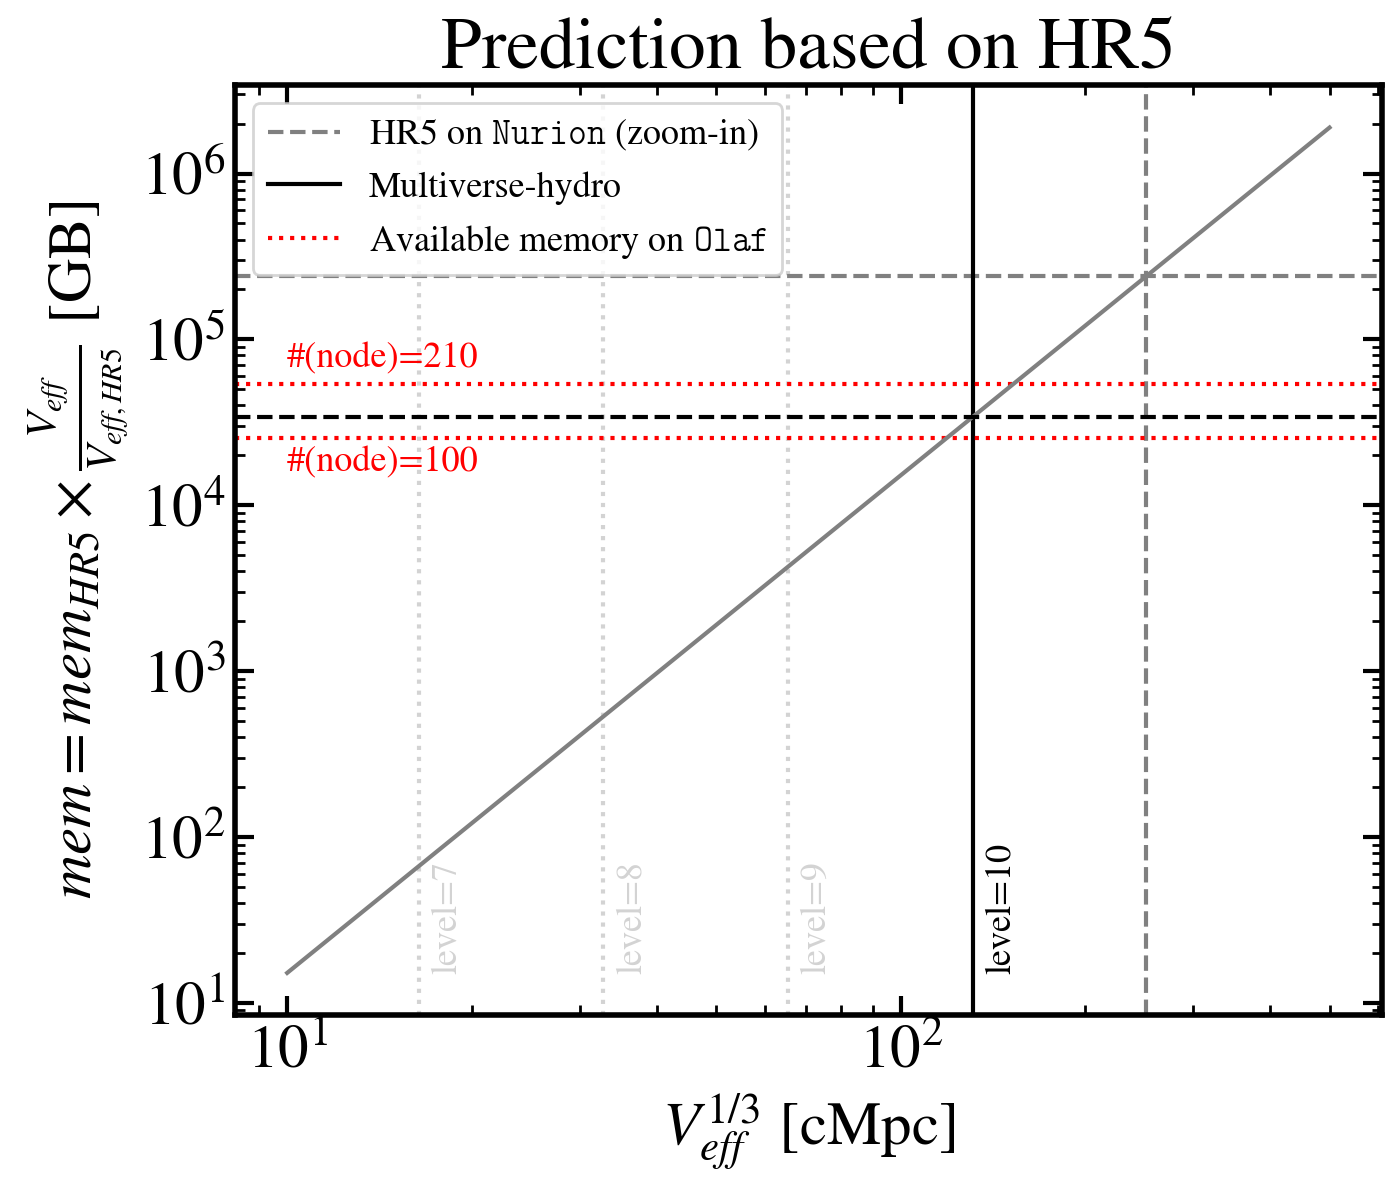

In [10]:
plt.figure(figsize=(7, 6))

# box size based on level
for lv in [7,8,9]:
    plt.axvline(compute_Lbox_cMpc(lv), c="lightgray", ls=":")
    plt.text(compute_Lbox_cMpc(lv) * 10**(0.02), 15, f"level={lv}", 
             fontsize=13, c="lightgray", rotation=90, ha="left", va="bottom")

# HR5 memory usage on Nurion
plt.axvline(hr5_Leff_cMpc, c="gray", ls="--", label=r"HR5 on $\mathtt{Nurion}$ (zoom-in)")
plt.axhline(hr5_mem, c="gray", ls="--")

# Available memeory on Olaf
plt.axvline(our_Lbox_cMpc, c="k", label="Multiverse-hydro")
plt.text(our_Lbox_cMpc * 10**(0.02), 15,
         f"level=10", fontsize=13, c="k", rotation=90, ha="left", va="bottom")
plt.axhline(olaf_tot_mem, c="r", ls=":", label=r"Available memory on $\mathtt{Olaf}$")
plt.axhline(olaf_our_mem, c="r", ls=":")
plt.text(10, olaf_tot_mem * 10**(0.05), f"#(node)={olaf_tot_node}", fontsize=13, c="r", ha="left", va="bottom")
plt.text(10, olaf_our_mem * 10**(-0.05),f"#(node)={olaf_our_node}", fontsize=13, c="r", ha="left", va="top")

# simple prediction based on HR5
xmin = 10
xmax = 500
x = np.logspace(np.log10(xmin), np.log10(xmax), 101)
y = simple_prediction(x**3, hr5_Veff_cMpc3, hr5_mem)
plt.loglog(x, y, c="gray")

# simple prediction for Multiverse-hydro
x = np.array(our_Lbox_cMpc)
y = simple_prediction(x**3, hr5_Veff_cMpc3, hr5_mem)
plt.axhline(y, c="k", ls="--")

plt.xlabel(r"$V_{eff}^{1/3}$ [cMpc]")
plt.ylabel(r"$mem = mem_{HR5} \times \frac{V_{eff}}{V_{eff,HR5}}$ [GB]")

plt.title("Prediction based on HR5")
plt.legend(loc=2, fontsize=13)
plt.tight_layout(pad=0.3)

In [11]:
x = np.array(our_Lbox_cMpc)
y = simple_prediction(x**3, hr5_Veff_cMpc3, hr5_mem)
print(y/olaf_mem_per_node) # minimum node ßnumbers on Olaf for 1 simulation

133.21752288489526


# Test runs

In [12]:
def extract_info(fname):
    
    with open(fname, 'r') as file:
        lines = file.readlines()
    
    time_tot = [] # executation time
    mem_tot  = [] # maximum memory per MPI rank
    main_tot = [] # main step (coarse level)
    
    for i, line in enumerate(lines):
        if "nproc" in line:
            nproc = int(line.split()[4])
            ndim  = int(line.split()[-1])
        if "Initial conditions for level" in line:
            level = int(line.split()[5])
#         if "Initial mesh structure" in line:
#             for j in range(level+1):
#                 print(lines[i+j])
        
        if "Used memory" in line:
            mem = line.split()[2]
            mem_tot.append(float(mem))
        if "Total running time" in line:
            time = line.split()[3]
            time_tot.append(float(time))
        if "Total elapsed time" in line:
            TIME_TOT = line.split()[3]
            TIME_TOT = float(TIME_TOT)
        if "Main step" in line:
            step = line.split()[2]
            step = int(step)
            main_tot.append(step)
    
    try:    
        MEM_TOT = np.max(mem_tot[1:]) * nproc
        print(f"{nproc} \t {MEM_TOT:6.2f} GB \t {TIME_TOT/3600/24:6.2f} days (done)")
        return nproc, level, np.array(main_tot), np.array(time_tot), np.array(mem_tot)[1:], TIME_TOT
    
    except NameError:
        print(f"{nproc} \t {MEM_TOT:6.2f} GB \t {time_tot[-1]/3600/24:6.2f} days (still running)")
        return nproc, level, np.array(main_tot), np.array(time_tot), np.array(mem_tot)[1:]

In [13]:
!tree .

.
├── C04-run-32-01-finished-o232528.txt
├── C04-run-hr5-32-01-finished-o233562.txt
├── C04-run-hr5-32-02-finished-o233564.txt
├── hr5-16-01.o14889190.olaf
├── hr5-16-02.o14889191.olaf
├── hr5-32-01-compiler.o14903364.olaf
├── hr5-32-01.o14889192.olaf
├── hr5-32-01-omp.o14903431.olaf
├── LCDM-1.o14930321.olaf
├── LCDM-2.o14907045.olaf
├── LCDM-2.o14916963.olaf
├── LCDM-2.o14920353.olaf
├── LCDM-3.o14919737.olaf
├── LCDM.o14904358.olaf
├── mem_tcpu.ipynb
├── run-128-01-killed-o232530.txt
├── run-128-02-segfault-o233036.txt
├── run-128-02-segfault-o233037.txt
├── run-16-01-finished-o232526.txt
├── run-16-02-segfault-o232527.txt
├── run-20-01-finished-o232433.txt
├── run-20-01-finished-o232434.txt
├── run-256-01-nomem-o232533.txt
├── run-32-01-finished-o232442.txt
├── run-32-02-segfault-o232525.txt
├── run-32-04-segfault-o232523.txt
├── run-64-01-finished-o232529.txt
├── run-64-04-segfault-o232524.txt
├── run-cpl-16-01-finished-o233558.txt
├── run-cpl-16-01-finished-o233769.txt
├── run-cp

In [14]:
!tree . | grep "finished"

├── C04-run-32-01-finished-o232528.txt
├── C04-run-hr5-32-01-finished-o233562.txt
├── C04-run-hr5-32-02-finished-o233564.txt
├── run-16-01-finished-o232526.txt
├── run-20-01-finished-o232433.txt
├── run-20-01-finished-o232434.txt
├── run-32-01-finished-o232442.txt
├── run-64-01-finished-o232529.txt
├── run-cpl-16-01-finished-o233558.txt
├── run-cpl-16-01-finished-o233769.txt
├── run-cpl2-32-01-finished-o233881.txt
├── run-cpl-32-01-finished-o233559.txt
├── run-cpl-32-01-finished-o233767.txt
├── run-cpl-32-02-finished-o233560.txt
├── run-cpl-32-02-finished-o233768.txt
├── run-cpl3-32-01-finished-o233882.txt
├── run-hr5-20-01-finished-o232435.txt
├── run-hr5-32-01-finished-o233157.txt
├── run-hr5-32-01-nsubcycle-finished-o233583.txt
├── run-hr5-32-02-finished-o233323.txt
├── run-hr5-32-04-finished-o233343.txt
├── run-hr5-32-04-nsubcycle-finished-o233843.txt
├── run-hr5-36-01-finished-o232617.txt


In [15]:
print("Glimpse look")
print("[grammar]")
print("ramses-bk")
_,_,_,_,_,_ = extract_info("./run-16-01-finished-o232526.txt")
_,_,_,_,_,_ = extract_info("./run-20-01-finished-o232434.txt")
_,_,_,_,_,_ = extract_info("./run-32-01-finished-o232442.txt")
_,_,_,_,_,_ = extract_info("./run-64-01-finished-o232529.txt")

print("ramses-hr5")
_,_,_,_,_,_ = extract_info("./run-hr5-20-01-finished-o232435.txt")
_,_,_,_,_,_ = extract_info("./run-hr5-32-01-finished-o233157.txt")
_,_,_,_,_,_ = extract_info("./run-hr5-32-01-nsubcycle-finished-o233583.txt")
_,_,_,_,_,_ = extract_info("./run-hr5-32-02-finished-o233323.txt")
_,_,_,_,_,_ = extract_info("./run-hr5-32-04-finished-o233343.txt")
_,_,_,_,_,_ = extract_info("./run-hr5-32-04-nsubcycle-finished-o233843.txt")
_,_,_,_,_,_ = extract_info("./run-hr5-36-01-finished-o232617.txt")

print("ramses-cpl")
_,_,_,_,_,_ = extract_info("./run-cpl-16-01-finished-o233769.txt")
_,_,_,_,_,_ = extract_info("./run-cpl-32-01-finished-o233767.txt")
_,_,_,_,_,_ = extract_info("./run-cpl-32-02-finished-o233768.txt")
_,_,_,_,_,_ = extract_info("./run-cpl2-32-01-finished-o233881.txt")
_,_,_,_,_,_ = extract_info("./run-cpl3-32-01-finished-o233882.txt")

Glimpse look
[grammar]
ramses-bk
16 	  56.00 GB 	   5.60 days (done)
20 	  68.00 GB 	   5.76 days (done)
32 	  96.00 GB 	   5.27 days (done)
64 	 160.00 GB 	   4.41 days (done)
ramses-hr5
20 	  40.00 GB 	   3.28 days (done)
32 	  54.40 GB 	   2.21 days (done)
32 	  54.40 GB 	   2.17 days (done)
32 	  48.00 GB 	   1.56 days (done)
32 	  48.00 GB 	   1.34 days (done)
32 	  51.20 GB 	   1.32 days (done)
36 	  50.40 GB 	   2.25 days (done)
ramses-cpl
20 	  40.00 GB 	   2.77 days (done)
32 	  54.40 GB 	   1.93 days (done)
32 	  51.20 GB 	   1.33 days (done)
32 	  54.40 GB 	   1.39 days (done)
32 	  54.40 GB 	   2.18 days (done)


In [17]:
# nsubcycle = 2,2,2,2,2,2,2
nproc0a, level0a, step0a, time0a, mem0a, ttot0a = extract_info("./run-hr5-32-01-nsubcycle-finished-o233583.txt")
nproc0b, level0b, step0b, time0b, mem0b, ttot0b = extract_info("./run-hr5-32-04-nsubcycle-finished-o233843.txt")

# nsubcycle = 1,1,2
nproc1, level1, step1, time1, mem1, ttot1 = extract_info("./run-hr5-32-01-finished-o233157.txt")
nproc2, level2, step2, time2, mem2, ttot2 = extract_info("./run-hr5-32-02-finished-o233323.txt")
nproc3, level3, step3, time3, mem3, ttot3 = extract_info("./run-hr5-32-04-finished-o233343.txt")

32 	  54.40 GB 	   2.17 days (done)
32 	  51.20 GB 	   1.32 days (done)
32 	  54.40 GB 	   2.21 days (done)
32 	  48.00 GB 	   1.56 days (done)
32 	  48.00 GB 	   1.34 days (done)


## Core test

<IPython.core.display.Javascript object>


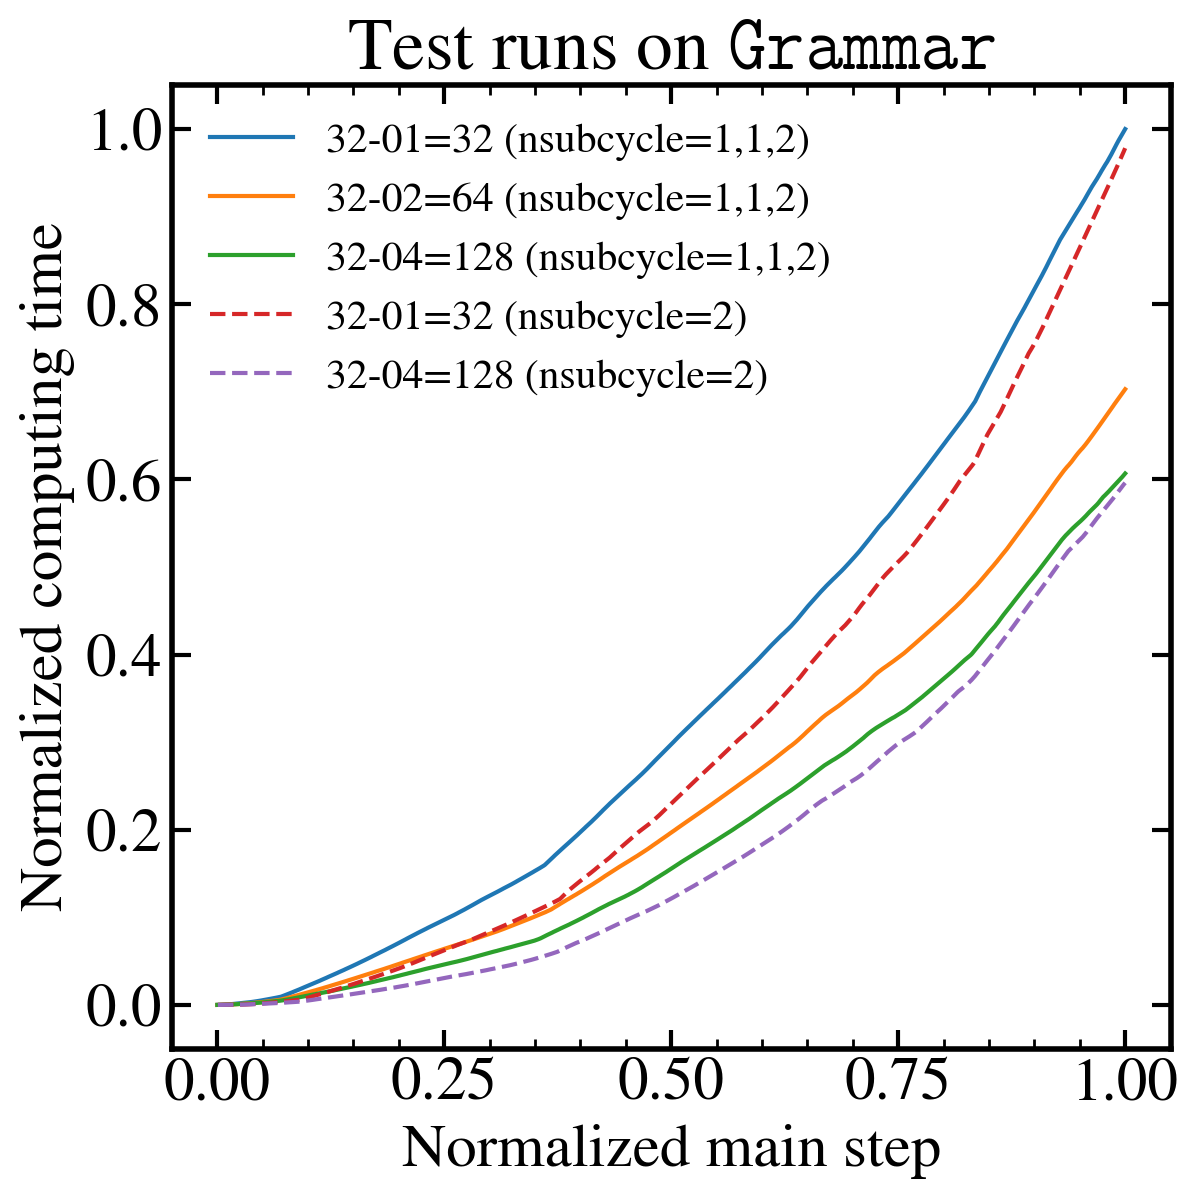

In [18]:
# fixed problem size
# changing cores

plt.figure(figsize=(6, 6))
plt.plot(step1/np.max(step1), time1/ttot1, label="32-01=32 (nsubcycle=1,1,2)")
plt.plot(step2/np.max(step2), time2/ttot1, label="32-02=64 (nsubcycle=1,1,2)")
plt.plot(step3/np.max(step3), time3/ttot1, label="32-04=128 (nsubcycle=1,1,2)")
plt.plot(step0a/np.max(step0a), time0a/ttot1, ls="--", label="32-01=32 (nsubcycle=2)")
plt.plot(step0b/np.max(step0b), time0b/ttot1, ls="--", label="32-04=128 (nsubcycle=2)")

plt.xlabel("Normalized main step")
plt.ylabel("Normalized computing time")
plt.legend(fontsize=15, frameon=False)
plt.title(r"Test runs on $\mathtt{Grammar}$")
plt.tight_layout(pad=0.3)

Why are the cases for nsubcycle=2 faster?

## CPL test

In [19]:
# CPL
nproc1c, level1c, step1c, time1c, mem1c, ttot1c = extract_info("./run-cpl-32-01-finished-o233767.txt")
nproc2c, level2c, step2c, time2c, mem2c, ttot1c = extract_info("./run-cpl-32-02-finished-o233768.txt")
nproc1c2, level1c2, step1c2, time1c2, mem1c2, ttot1c2 = extract_info("./run-cpl2-32-01-finished-o233881.txt")
nproc1c3, level1c3, step1c3, time1c3, mem1c3, ttot1c3 = extract_info("./run-cpl3-32-01-finished-o233882.txt")

32 	  54.40 GB 	   1.93 days (done)
32 	  51.20 GB 	   1.33 days (done)
32 	  54.40 GB 	   1.39 days (done)
32 	  54.40 GB 	   2.18 days (done)


In [20]:
len(step1), len(step1c), len(step2c), len(step1c2), len(step1c3)

(5284, 4739, 4765, 4135, 4881)

Why the number of main steps for nsubcycle is much smaller than others?  

<IPython.core.display.Javascript object>


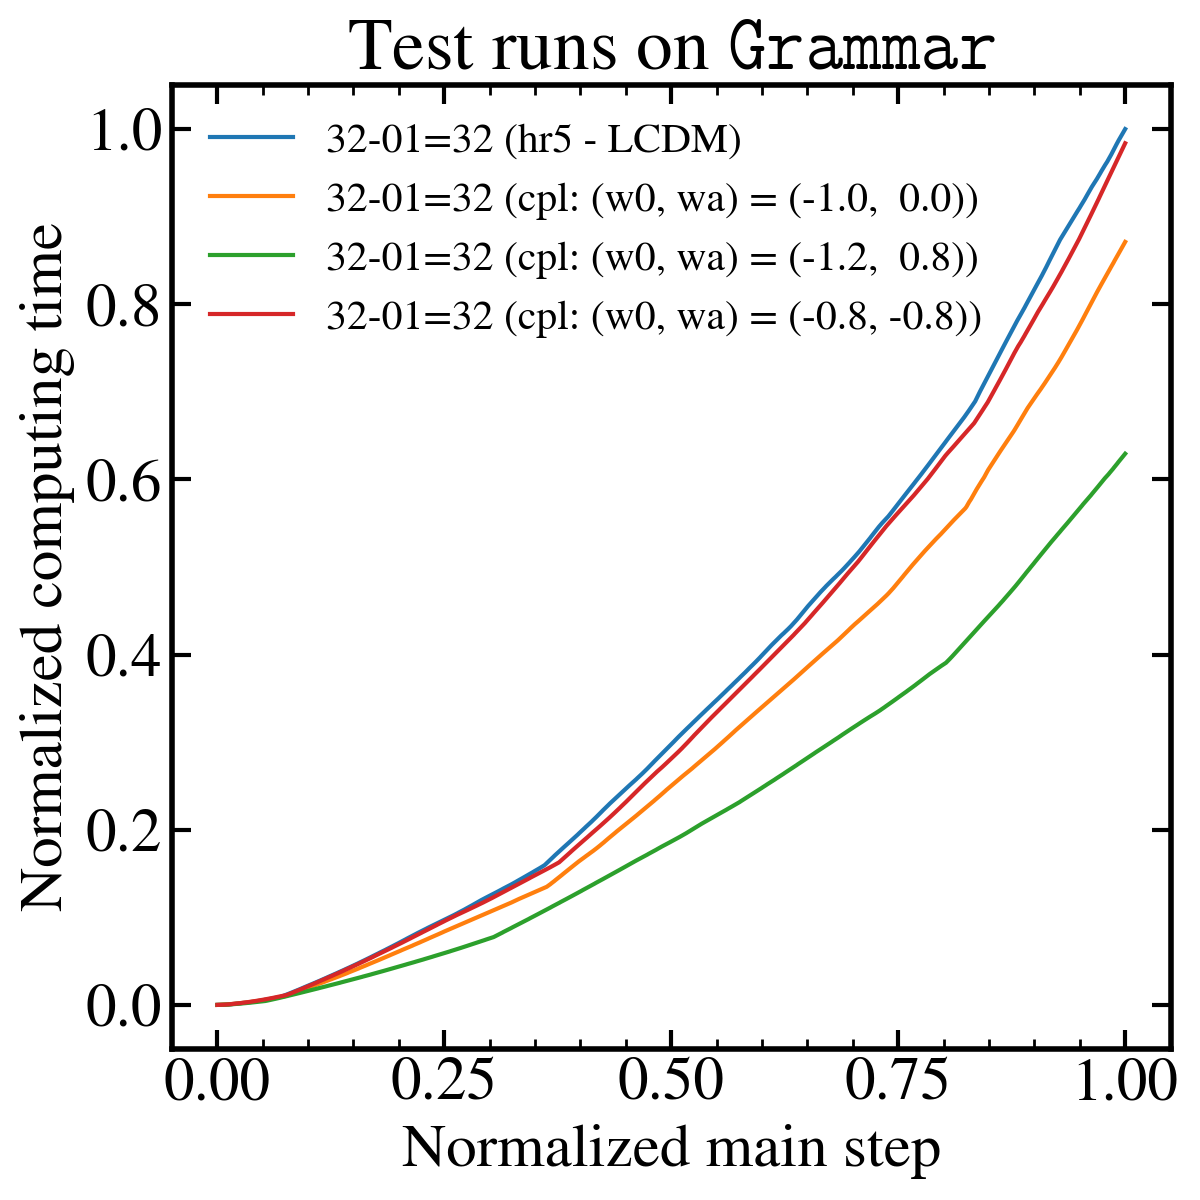

In [21]:
plt.figure(figsize=(6, 6))
plt.plot(step1/np.max(step1), time1/ttot1, label="32-01=32 (hr5 - LCDM)")
plt.plot(step1c/np.max(step1c), time1c/ttot1, label="32-01=32 (cpl: (w0, wa) = (-1.0,  0.0))")
plt.plot(step1c2/np.max(step1c2), time1c2/ttot1, label="32-01=32 (cpl: (w0, wa) = (-1.2,  0.8))")
plt.plot(step1c3/np.max(step1c3), time1c3/ttot1, label="32-01=32 (cpl: (w0, wa) = (-0.8, -0.8))")

plt.xlabel("Normalized main step")
plt.ylabel("Normalized computing time")
plt.legend(fontsize=15, frameon=False)
plt.title(r"Test runs on $\mathtt{Grammar}$")
plt.tight_layout(pad=0.3)

Do w0 & wa impact on computation time? How?

## Olaf test

In [22]:
!tree . | grep "olaf"

├── hr5-16-01.o14889190.olaf
├── hr5-16-02.o14889191.olaf
├── hr5-32-01-compiler.o14903364.olaf
├── hr5-32-01.o14889192.olaf
├── hr5-32-01-omp.o14903431.olaf
├── LCDM-1.o14930321.olaf
├── LCDM-2.o14907045.olaf
├── LCDM-2.o14916963.olaf
├── LCDM-2.o14920353.olaf
├── LCDM-3.o14919737.olaf
├── LCDM.o14904358.olaf


In [23]:
nproc1o, level1o, step1o, time1o, mem1o = extract_info("./hr5-16-01.o14889190.olaf")
nproc2o, level2o, step2o, time2o, mem2o = extract_info("./hr5-16-02.o14889191.olaf")
nproc3o, level3o, step3o, time3o, mem3o = extract_info("./hr5-32-01.o14889192.olaf")

16 	  43.20 GB 	   3.91 days (still running)
16 	  43.20 GB 	   2.97 days (still running)
32 	  44.80 GB 	   2.96 days (still running)


In [24]:
_,_,step,time,mem,_ = extract_info("./run-cpl-16-01-finished-o233769.txt")

20 	  40.00 GB 	   2.77 days (done)


<IPython.core.display.Javascript object>


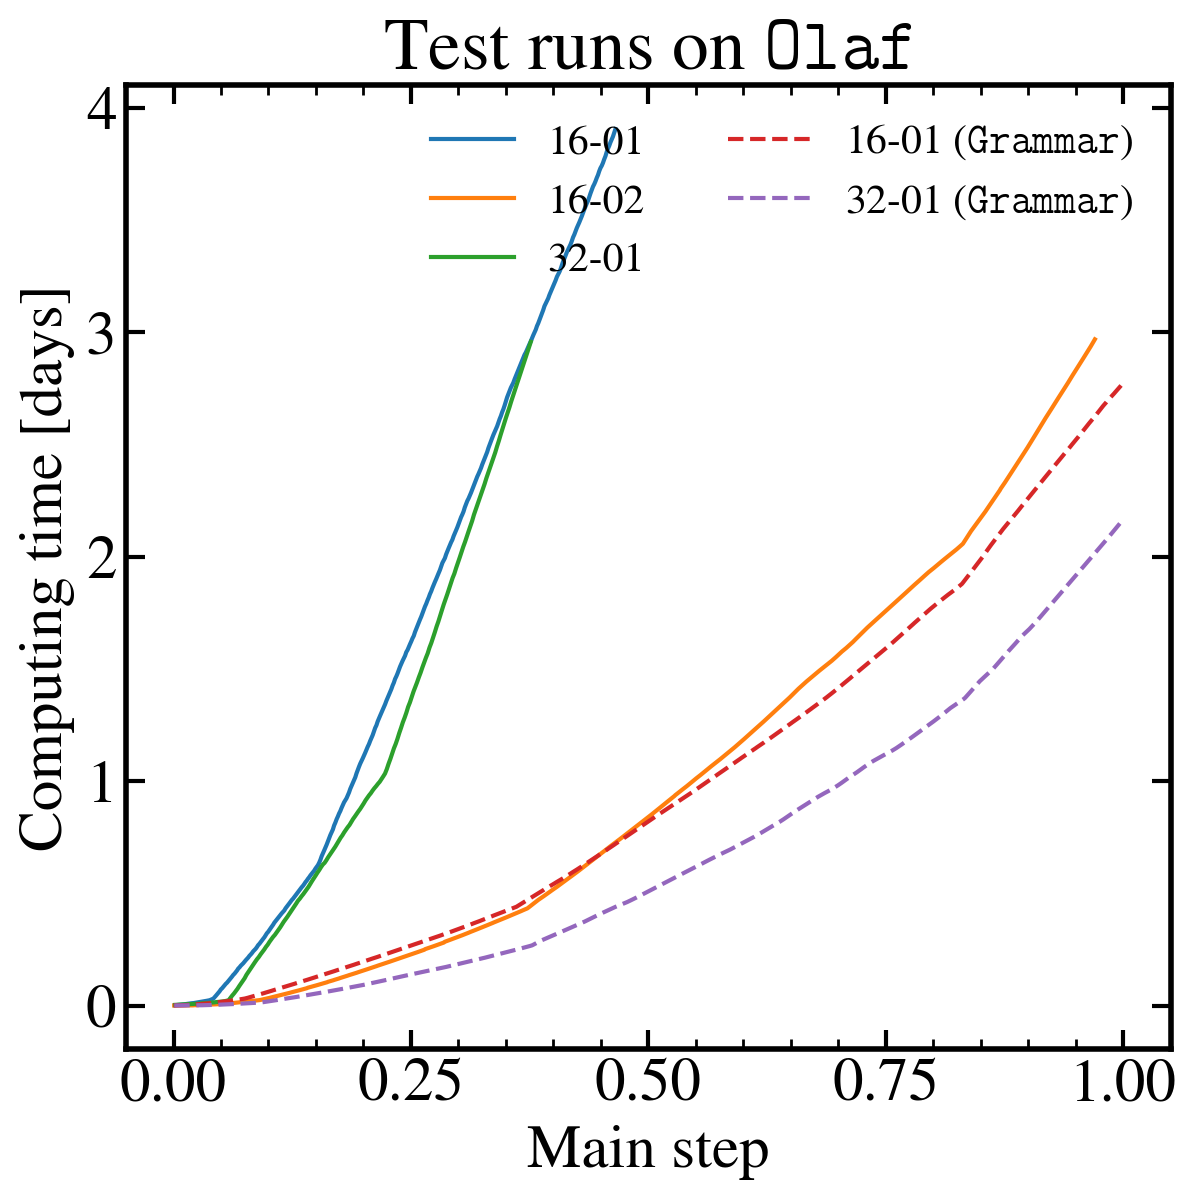

In [25]:
plt.figure(figsize=(6, 6))

# the last snapshot number = 47 for run-hr5-16-01
# the last snapshot number = 98 for run-hr5-16-02
# the last snapshot number = 38 for run-hr5-32-01

plt.plot(step1o/np.max(step1o)*47/101, time1o/3600/24, label="16-01")
plt.plot(step2o/np.max(step2o)*98/101, time2o/3600/24, label="16-02")
plt.plot(step3o/np.max(step3o)*38/101, time3o/3600/24, label="32-01")
plt.plot(step/np.max(step), time/3600/24, ls="--", label=r"16-01 ($\mathtt{Grammar}$)")
plt.plot(step0a/np.max(step0a), time0a/3600/24, ls="--", label=r"32-01 ($\mathtt{Grammar}$)")
plt.xlabel("Main step")
plt.ylabel("Computing time [days]")
plt.legend(fontsize=15, frameon=False, ncols=2)
plt.title(r"Test runs on $\mathtt{Olaf}$")
plt.tight_layout(pad=0.3)

Why Olaf is so slow..?  
There must be something wrong for nthread = 1:  
- Changing the compiler? --> not solution
- Commenting out OMP? --> not solution
- Setting OMP=cores? --> a bit faster but not still slower than nthread=2

In [26]:
!tree . | grep "olaf"

├── hr5-16-01.o14889190.olaf
├── hr5-16-02.o14889191.olaf
├── hr5-32-01-compiler.o14903364.olaf
├── hr5-32-01.o14889192.olaf
├── hr5-32-01-omp.o14903431.olaf
├── LCDM-1.o14930321.olaf
├── LCDM-2.o14907045.olaf
├── LCDM-2.o14916963.olaf
├── LCDM-2.o14920353.olaf
├── LCDM-3.o14919737.olaf
├── LCDM.o14904358.olaf


- hr5-16-01.o14889190.olaf  
- hr5-16-02.o14889191.olaf  
- hr5-32-01-compiler.o14903364.olaf  : Changing the compiler
- hr5-32-01.o14889192.olaf  
- hr5-32-01-omp.o14903431.olaf: Commenting out `export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK`?
- LCDM-1.o14930321.olaf: Setting `export OMP_PLACES=cores`
- LCDM-2.o14907045.olaf  
- LCDM-2.o14916963.olaf  
- LCDM-2.o14920353.olaf  
- LCDM-3.o14919737.olaf  
- LCDM.o14904358.olaf  

# Required memory

In [51]:
def extract_info(fname):
    _ = 0
    
    with open(fname, 'r') as file:
        lines = file.readlines()
    
    time_tot = [] # executation time
    mem_tot  = [] # maximum memory per MPI rank
    main_tot = [] # main step (coarse level)
    
    for i, line in enumerate(lines):
        if "nproc" in line:
            nproc = int(line.split()[4])
            ndim  = int(line.split()[-1])
        if "Initial conditions for level" in line:
            level = int(line.split()[5])
#         if "Initial mesh structure" in line:
#             for j in range(level+1):
#                 print(lines[i+j])
        
        if "Gb" in line:
#             print(line)
            mem = line.split()[2]
            mem_tot.append(float(mem))
            
        if "Total running time" in line:
            time = line.split()[3]
            time_tot.append(float(time))
        if "Total elapsed time" in line:
            TIME_TOT = line.split()[3]
            TIME_TOT = float(TIME_TOT)
        if "Main step" in line:
            step = line.split()[2]
            step = int(step)
            main_tot.append(step)
    
    return nproc, _, main_tot, time_tot, mem_tot

In [72]:
nproc1oo, level1oo, step1oo, time1oo, mem1oo = extract_info("./LCDM.o14904358.olaf")
nproc2oo, level2oo, step2oo, time2oo, mem2oo = extract_info("./LCDM-2.o14907045.olaf")
nproc3oo, level3oo, step3oo, time3oo, mem3oo = extract_info("./LCDM-2.o14916963.olaf")
nproc4oo, level4oo, step4oo, time4oo, mem4oo = extract_info("./LCDM-2.o14920353.olaf")

In [73]:
print(len(step1oo), len(mem1oo))
print(len(step2oo), len(mem2oo))
print(len(step3oo), len(mem3oo))
print(len(step4oo), len(mem4oo))

271 271
534 535
35 36
1257 1259


<IPython.core.display.Javascript object>


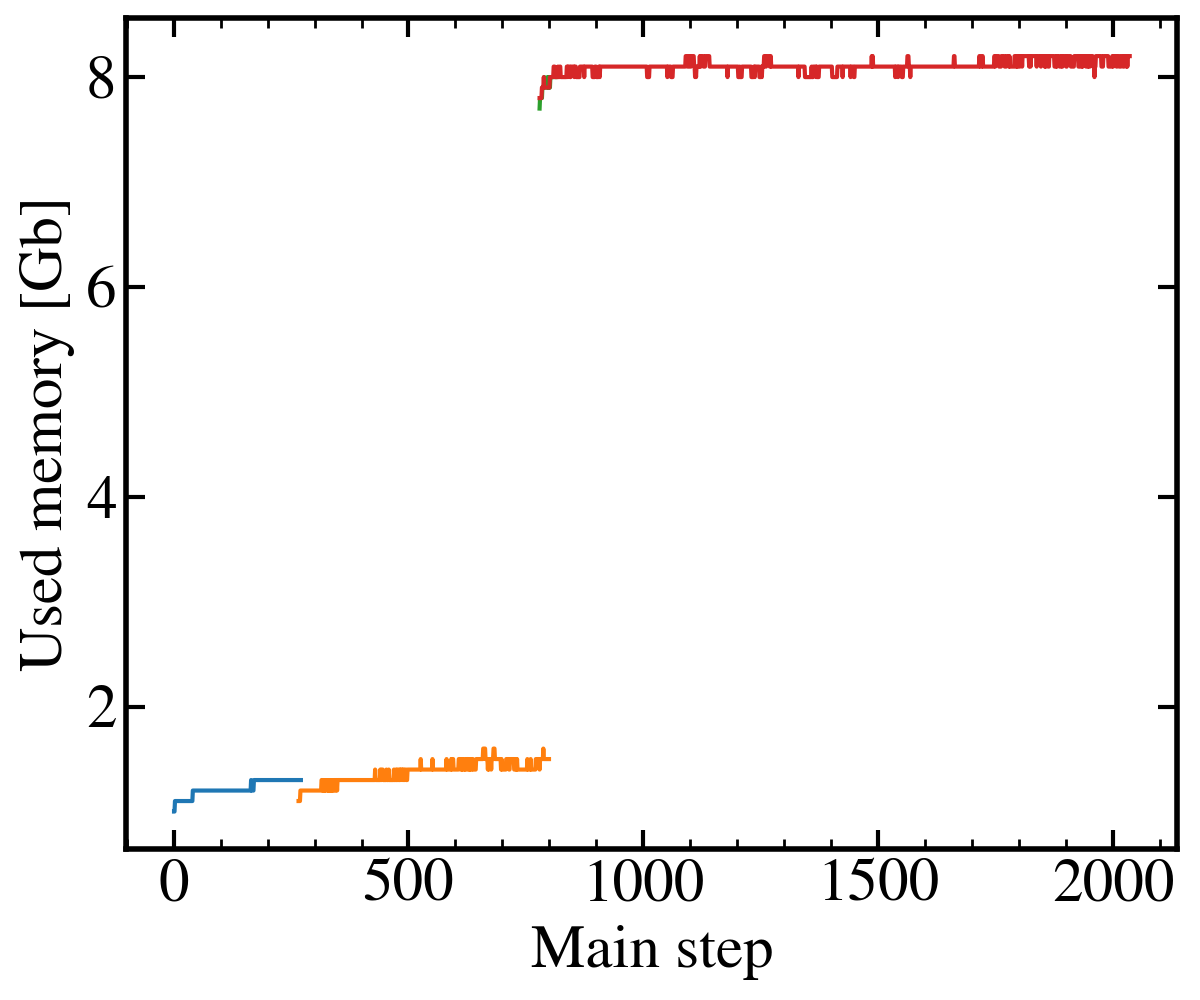

In [74]:
plt.figure(figsize=(6, 5))
plt.plot(step1oo, mem1oo)
plt.plot(step2oo, mem2oo[1:])
plt.plot(step3oo, mem3oo[1:])
plt.plot(step4oo, mem4oo[2:])
plt.xlabel("Main step")
plt.ylabel("Used memory [Gb]")
plt.tight_layout(pad=0.3)

Why is there a jump?

<IPython.core.display.Javascript object>


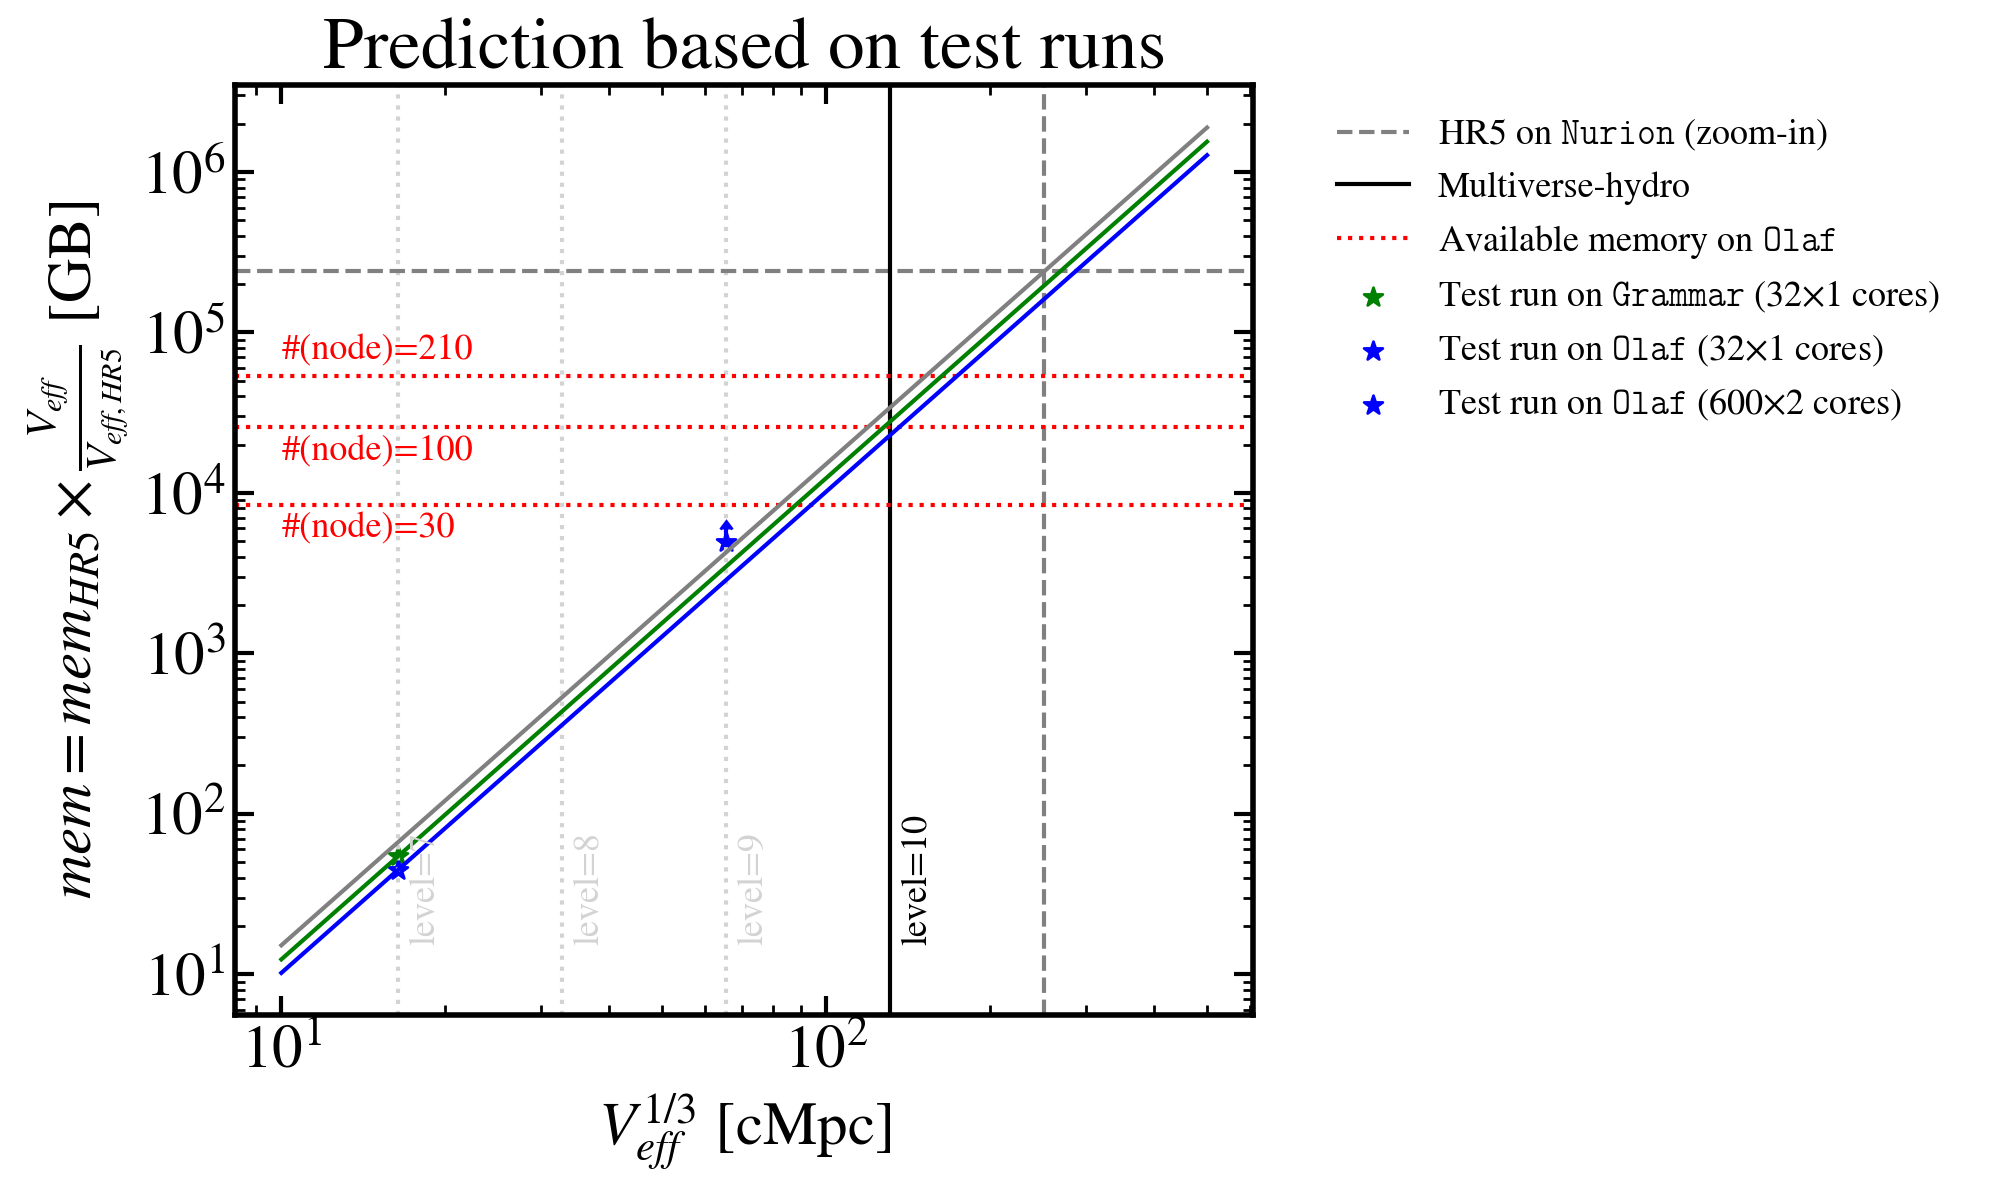

In [93]:
plt.figure(figsize=(10, 6))

xmin, xmax = 10, 500
ymin = simple_prediction(xmin**3, hr5_Veff_cMpc3, hr5_mem)
ymax = simple_prediction(xmax**3, hr5_Veff_cMpc3, hr5_mem)

# box size based on level
for lv in [7,8,9]:
    plt.axvline(compute_Lbox_cMpc(lv), c="lightgray", ls=":")
    plt.text(compute_Lbox_cMpc(lv) * 10**(0.02), ymin, f"level={lv}", 
             fontsize=13, c="lightgray", rotation=90, ha="left", va="bottom")

# HR5 memory usage on Nurion
# plt.scatter(hr5_Leff_cMpc, hr5_mem, c="gray", marker="*", s=100, label=r"HR5 on $\mathtt{Nurion}$ (zoom-in)")
plt.axvline(hr5_Leff_cMpc, c="gray", ls="--", label=r"HR5 on $\mathtt{Nurion}$ (zoom-in)")
plt.axhline(hr5_mem, c="gray", ls="--")

# Available memeory on Olaf
plt.axvline(our_Lbox_cMpc, c="k", label="Multiverse-hydro")
plt.text(our_Lbox_cMpc * 10**(0.02), ymin,
         f"level=10", fontsize=13, c="k", rotation=90, ha="left", va="bottom")
plt.axhline(olaf_tot_mem, c="r", ls=":", label=r"Available memory on $\mathtt{Olaf}$")
plt.axhline(olaf_our_mem, c="r", ls=":")
plt.axhline(256*33, c="r", ls=":")
plt.text(xmin, olaf_tot_mem * 10**(0.05), f"#(node)={olaf_tot_node}", fontsize=13, c="r", ha="left", va="bottom")
plt.text(xmin, olaf_our_mem * 10**(-0.05),f"#(node)={olaf_our_node}", fontsize=13, c="r", ha="left", va="top")
plt.text(xmin, 256*33 * 10**(-0.05),f"#(node)=30", fontsize=13, c="r", ha="left", va="top")

# simple prediction based on HR5
x = np.logspace(np.log10(xmin), np.log10(xmax), 101)
y = simple_prediction(x**3, hr5_Veff_cMpc3, hr5_mem)
plt.loglog(x, y, c="gray")




# Test run result on Grammer
plt.scatter(compute_Lbox_cMpc(level1), np.max(mem1)*nproc1, c='g', alpha=1.0, marker="*", s=50, label=r"Test run on $\mathtt{Grammar}$ (32$\times$1 cores)")
# plt.scatter(compute_Lbox_cMpc(level2), np.max(mem2)*nproc2, c='g', alpha=0.7, marker="*", s=50, label=r"Test run on $\mathtt{Grammar}$ (32$\times$2 cores)")
# plt.scatter(compute_Lbox_cMpc(level3), np.max(mem3)*nproc3, c='g', alpha=0.3, marker="*", s=50, label=r"Test run on $\mathtt{Grammar}$ (32$\times$4 cores)")
x = np.logspace(np.log10(xmin), np.log10(xmax), 101)
y = simple_prediction(x**3, compute_Lbox_cMpc(level1)**3, np.max(mem1)*nproc1)
plt.loglog(x, y, c='g')




# Test run result on Olaf
plt.scatter(compute_Lbox_cMpc(level3o), np.max(mem3o)*nproc3o, c='b', alpha=1.0, marker="*", s=50, label=r"Test run on $\mathtt{Olaf}$ (32$\times$1 cores)")
# plt.scatter(compute_Lbox_cMpc(level2o), np.max(mem2o)*nproc2o, c='b', alpha=1.0, marker="*", s=50, label=r"Test run on $\mathtt{Olaf}$ (16$\times$2 cores)")
plt.scatter(compute_Lbox_cMpc(9), np.max(mem4oo)*nproc4oo, c='b', alpha=1.0, marker="*", s=50, label=r"Test run on $\mathtt{Olaf}$ (600$\times$2 cores)")
plt.errorbar(compute_Lbox_cMpc(9), np.max(mem4oo)*nproc4oo, yerr=1000, lolims=True, capsize=2, c='b')
x = np.logspace(np.log10(xmin), np.log10(xmax), 101)
y = simple_prediction(x**3, compute_Lbox_cMpc(level3o)**3, np.max(mem3o)*nproc3o)
plt.loglog(x, y, c='b')



# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)

plt.xlabel(r"$V_{eff}^{1/3}$ [cMpc]")
plt.ylabel(r"$mem = mem_{HR5} \times \frac{V_{eff}}{V_{eff,HR5}}$ [GB]")

plt.title("Prediction based on test runs")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False, ncol=1, fontsize=13)

plt.tight_layout(pad=0.3)

# CPU time

In [94]:
olaf_node_time = 63000 # hr

print(f"Total node time: {olaf_node_time:,.0f} hr")
print(f"Execution time:")
print(f"  using {olaf_tot_node} nodes: {olaf_node_time / olaf_tot_node / 24} days")
print(f"  using {olaf_our_node} nodes: {olaf_node_time / olaf_our_node / 24} days")
olaf_exe_time = olaf_node_time / olaf_our_node / 24

Total node time: 63,000 hr
Execution time:
  using 210 nodes: 12.5 days
  using 100 nodes: 26.25 days


In [95]:
olaf_cpu_per_node = 72
olaf_cpu_time     = olaf_node_time * olaf_cpu_per_node # hr
# Should I multiply `nthread` or not?
# Even if we use hyperthreading, it won't reduce the cpu time very much
# So I do not consider `nthread` hrere.

print(olaf_cpu_time)

4536000


In [96]:
hr5_tcpu1 = 1 * 31 * 24 * 1250 * 68 # hr
hr5_tcpu2 = 2 * 30 * 24 * 2500 * 68 # hr

In [97]:
hr5_cpu_time = hr5_tcpu1 + hr5_tcpu2
hr5_cpu_time

308040000

In [98]:
def extract_info(fname):
    
    with open(fname, 'r') as file:
        lines = file.readlines()
    
    time_tot = [] # executation time
    mem_tot  = [] # maximum memory per MPI rank
    main_tot = [] # main step (coarse level)
    
    for i, line in enumerate(lines):
        if "nproc" in line:
            nproc = int(line.split()[4])
            ndim  = int(line.split()[-1])
        if "Initial conditions for level" in line:
            level = int(line.split()[5])
#         if "Initial mesh structure" in line:
#             for j in range(level+1):
#                 print(lines[i+j])
        
        if "Used memory" in line:
            mem = line.split()[2]
            mem_tot.append(float(mem))
        if "Total running time" in line:
            time = line.split()[3]
            time_tot.append(float(time))
        if "Total elapsed time" in line:
            TIME_TOT = line.split()[3]
            TIME_TOT = float(TIME_TOT)
        if "Main step" in line:
            step = line.split()[2]
            step = int(step)
            main_tot.append(step)
    
    try:    
        MEM_TOT = np.max(mem_tot[1:]) * nproc
        print(f"{nproc} \t {MEM_TOT:6.2f} GB \t {TIME_TOT/3600/24:6.2f} days (done)")
        return nproc, level, np.array(main_tot), np.array(time_tot), np.array(mem_tot)[1:], TIME_TOT
    
    except NameError:
        print(f"{nproc} \t {MEM_TOT:6.2f} GB \t {time_tot[-1]/3600/24:6.2f} days (still running)")
        return nproc, level, np.array(main_tot), np.array(time_tot), np.array(mem_tot)[1:]

In [99]:
print("ramses-bk")
_,_,_,_,_,texe_16_01 = extract_info("./run-16-01-finished-o232526.txt")
_,_,_,_,_,texe_20_01 = extract_info("./run-20-01-finished-o232434.txt")
_,_,_,_,_,texe_32_01 = extract_info("./run-32-01-finished-o232442.txt")
_,_,_,_,_,texe_64_01 = extract_info("./run-64-01-finished-o232529.txt")

print("ramses-hr5")
_,_,_,_,_,texe_hr5_20_01 = extract_info("./run-hr5-20-01-finished-o232435.txt")
_,_,_,_,_,texe_hr5_32_01 = extract_info("./run-hr5-32-01-finished-o233157.txt")
_,_,_,_,_,texe_hr5_32_02 = extract_info("./run-hr5-32-02-finished-o233323.txt")
_,_,_,_,_,texe_hr5_32_04 = extract_info("./run-hr5-32-04-finished-o233343.txt")
_,_,_,_,_,texe_hr5_36_01 = extract_info("./run-hr5-36-01-finished-o232617.txt")

print("ramses-cpl")
_,_,_,_,_,texe_cpl_16_01 = extract_info("./run-cpl-16-01-finished-o233769.txt")
_,_,_,_,_,texe_cpl_32_01 = extract_info("./run-cpl-32-01-finished-o233767.txt")
_,_,_,_,_,texe_cpl_32_02 = extract_info("./run-cpl-32-02-finished-o233768.txt")
_,_,_,_,_,texe_cpl2_32_01 = extract_info("./run-cpl2-32-01-finished-o233881.txt")
_,_,_,_,_,texe_cpl3_32_01 = extract_info("./run-cpl3-32-01-finished-o233882.txt")

ramses-bk
16 	  56.00 GB 	   5.60 days (done)
20 	  68.00 GB 	   5.76 days (done)
32 	  96.00 GB 	   5.27 days (done)
64 	 160.00 GB 	   4.41 days (done)
ramses-hr5
20 	  40.00 GB 	   3.28 days (done)
32 	  54.40 GB 	   2.21 days (done)
32 	  48.00 GB 	   1.56 days (done)
32 	  48.00 GB 	   1.34 days (done)
36 	  50.40 GB 	   2.25 days (done)
ramses-cpl
20 	  40.00 GB 	   2.77 days (done)
32 	  54.40 GB 	   1.93 days (done)
32 	  51.20 GB 	   1.33 days (done)
32 	  54.40 GB 	   1.39 days (done)
32 	  54.40 GB 	   2.18 days (done)


<IPython.core.display.Javascript object>


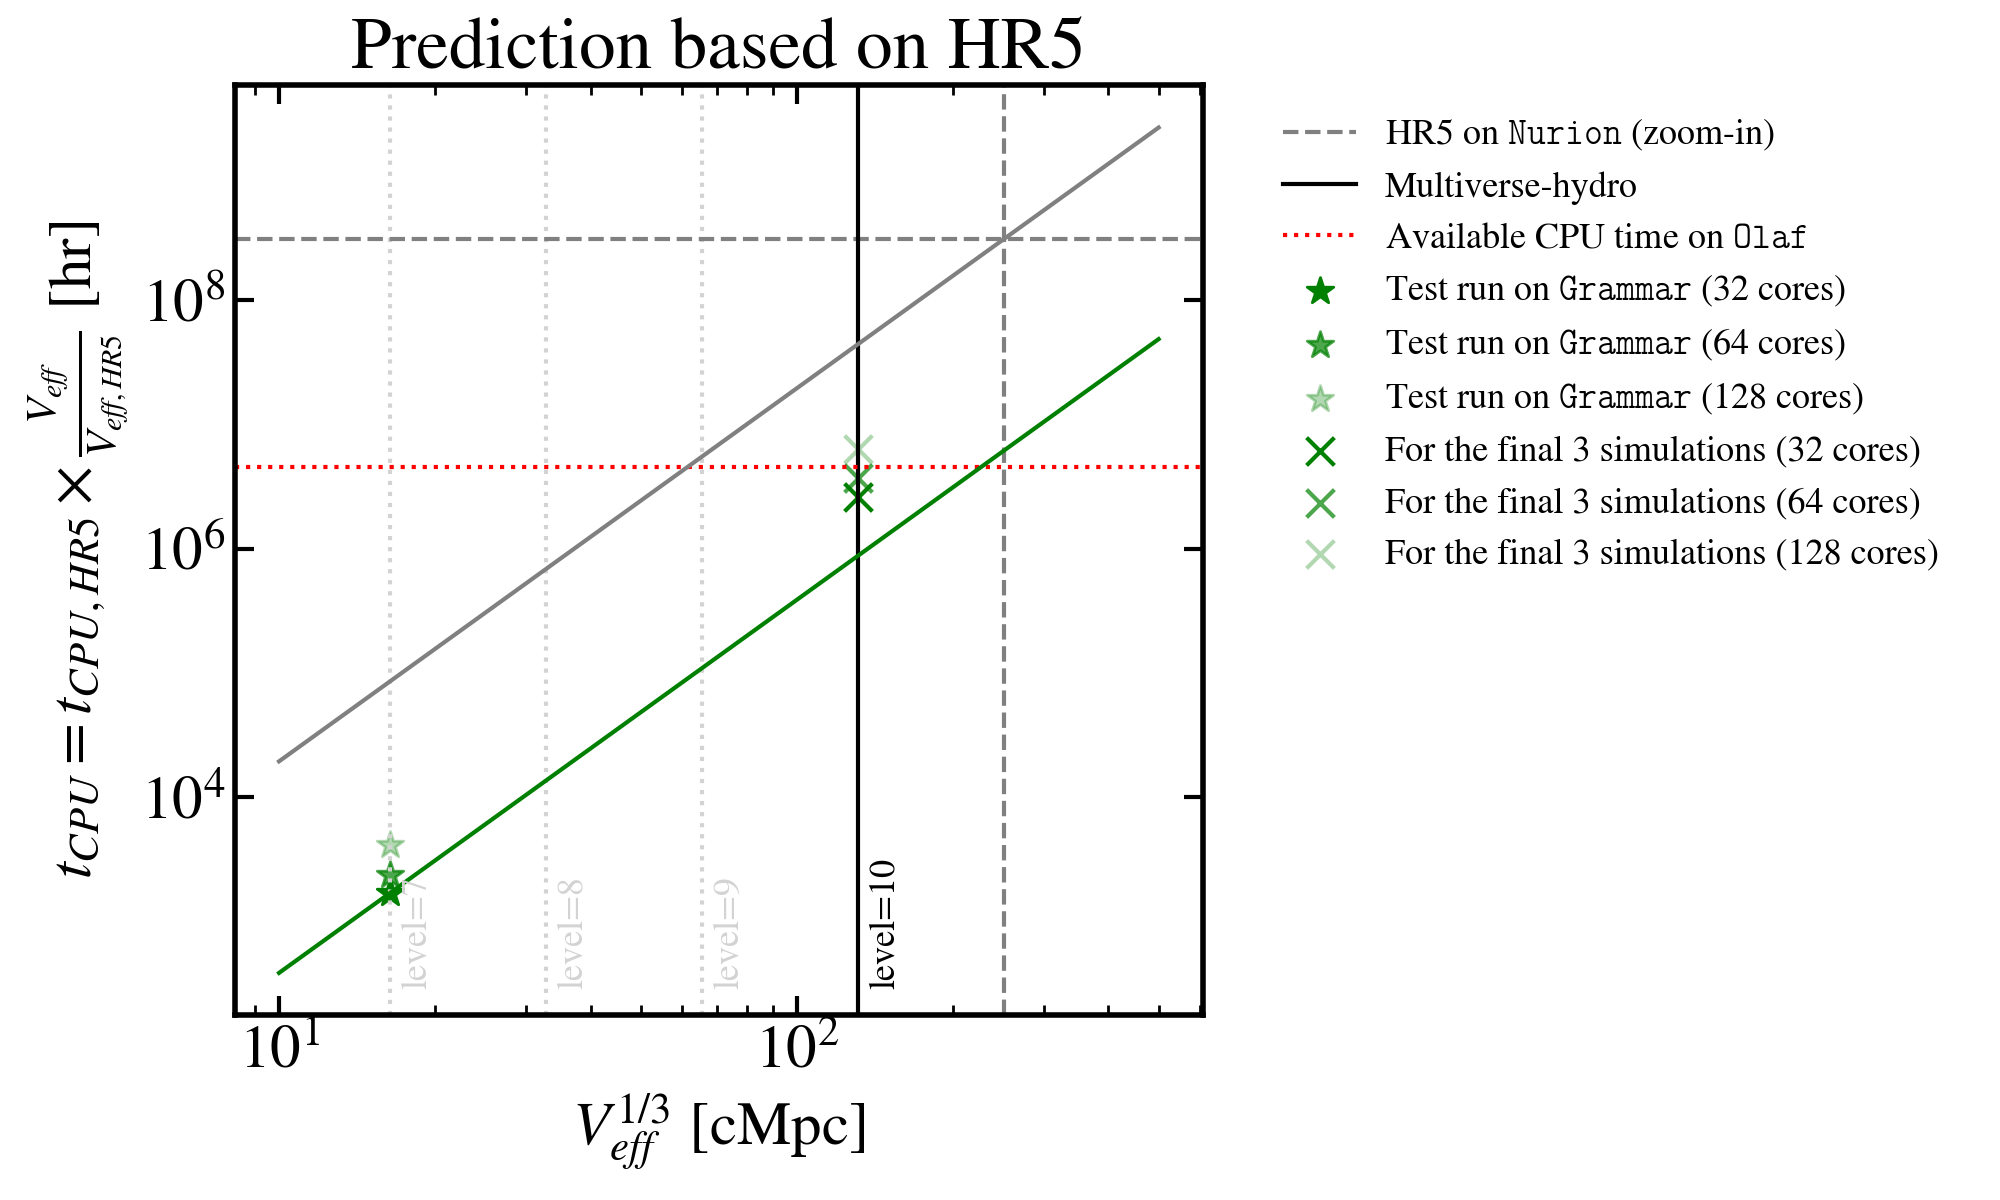

In [101]:
plt.figure(figsize=(10, 6))

xmin, xmax = 10, 500
ymin = simple_prediction(xmin**3, hr5_Veff_cMpc3, olaf_cpu_time)
ymax = simple_prediction(xmax**3, hr5_Veff_cMpc3, hr5_cpu_time)

for lv in [7,8,9]:
    plt.axvline(compute_Lbox_cMpc(lv, 1, 1), c="lightgray", ls=":")
    plt.text(compute_Lbox_cMpc(lv, 1, 1) * 1.05, ymin, f"level={lv}", 
             fontsize=13, c="lightgray", rotation=90, ha="left", va="bottom")

plt.axvline(hr5_Leff_cMpc, c="gray", ls="--", label=r"HR5 on $\mathtt{Nurion}$ (zoom-in)")
plt.axhline(hr5_cpu_time,  c="gray", ls="--")
plt.axvline(our_Lbox_cMpc, c="k", label="Multiverse-hydro")
plt.axhline(olaf_cpu_time, c="r", ls=":", label=r"Available CPU time on $\mathtt{Olaf}$")
plt.text(our_Lbox_cMpc * 1.05, ymin, f"level=10", 
         fontsize=13, c="k", rotation=90, ha="left", va="bottom")


x = np.logspace(np.log10(xmin), np.log10(xmax), 101)
y = simple_prediction(x**3, hr5_Veff_cMpc3, hr5_cpu_time)
plt.loglog(x, y, c="gray")


# plt.scatter(compute_Lbox_cMpc(7,1,1), texe_16/3600*16, c="#B388FF")
# plt.scatter(compute_Lbox_cMpc(7,1,1), texe_32/3600*32, c="#7C4DFF")
# plt.scatter(compute_Lbox_cMpc(7,1,1), texe_64/3600*64, c="#6200EA")

plt.scatter(compute_Lbox_cMpc(7,1,1), texe_hr5_32_01/3600*32, marker="*", s=100, c="g", label=r"Test run on $\mathtt{Grammar}$ (32 cores)")
plt.scatter(compute_Lbox_cMpc(7,1,1), texe_hr5_32_02/3600*64, marker="*", s=100, c="g", alpha=0.7, label=r"Test run on $\mathtt{Grammar}$ (64 cores)")
plt.scatter(compute_Lbox_cMpc(7,1,1), texe_hr5_32_04/3600*128, marker="*", s=100, c="g", alpha=0.3, label=r"Test run on $\mathtt{Grammar}$ (128 cores)")

x = np.logspace(1, np.log10(500), 101)
y = simple_prediction(x**3, compute_Lbox_cMpc(7,1,1)**3, texe_hr5_32_01/3600*32)
plt.loglog(x, y, c="g")

x = np.array(our_Lbox_cMpc)
y = simple_prediction(x**3, compute_Lbox_cMpc(7,1,1)**3, texe_hr5_32_01/3600*32)
plt.scatter(x, 3*y, marker="x", s=100, c="g", alpha=1.0, label="For the final 3 simulations (32 cores)")

y = simple_prediction(x**3, compute_Lbox_cMpc(7,1,1)**3, texe_hr5_32_02/3600*64)
plt.scatter(x, 3*y, marker="x", s=100, c="g", alpha=0.7, label="For the final 3 simulations (64 cores)")

y = simple_prediction(x**3, compute_Lbox_cMpc(7,1,1)**3, texe_hr5_32_04/3600*128)
plt.scatter(x, 3*y, marker="x", s=100, c="g", alpha=0.3, label="For the final 3 simulations (128 cores)")


# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)

plt.xlabel(r"$V_{eff}^{1/3}$ [cMpc]")
plt.ylabel(r"$t_{CPU} = t_{CPU,HR5} \times \frac{V_{eff}}{V_{eff,HR5}}$ [hr]")

plt.title("Prediction based on HR5")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False, ncol=1, fontsize=13)

plt.tight_layout(pad=0.3)

# Speed based on OMP threads

In [20]:
!tree . | grep "olaf"

├── hr5-16-01.o14889190.olaf
├── hr5-16-02.o14889191.olaf
├── hr5-32-01-compiler.o14903364.olaf
├── hr5-32-01.o14889192.olaf
├── hr5-32-01-omp.o14903431.olaf
├── LCDM-1.o14930321.olaf
├── LCDM-2.o14907045.olaf
├── LCDM-2.o14916963.olaf
├── LCDM-2.o14920353.olaf
├── LCDM-3.o14919737.olaf
├── LCDM.o14904358.olaf


In [102]:
def particle_per_time(fname):
    step_c = []
    tpp1 = []
    tpp2 = []

    with open(fname, 'r') as file:
        lines = file.readlines()

        for line in lines:
            if "Main" in line:
                step_c.append(int(line.split()[2]))

        for line in lines:
            if "mus/pt" in line:
                tpp1.append(float(line.split()[8]))
                tpp2.append(float(line.split()[10]))

    log = {}
    log["step_c"] = step_c
    log["tpp1"]   = tpp1[1:] # time per particle
    log["tpp2"]   = tpp2[1:] # time paer particle (average)

    return log

In [103]:
log  = particle_per_time("./LCDM.o14904358.olaf")
log1 = particle_per_time("./LCDM-1.o14930321.olaf")
log2a = particle_per_time("./LCDM-2.o14907045.olaf")
log2b = particle_per_time("./LCDM-2.o14916963.olaf")
log2c = particle_per_time("./LCDM-2.o14920353.olaf")
log3  = particle_per_time("./LCDM-3.o14919737.olaf")

In [104]:
log3

{'step_c': [779, 780], 'tpp1': [286.39], 'tpp2': [286.39]}

<IPython.core.display.Javascript object>


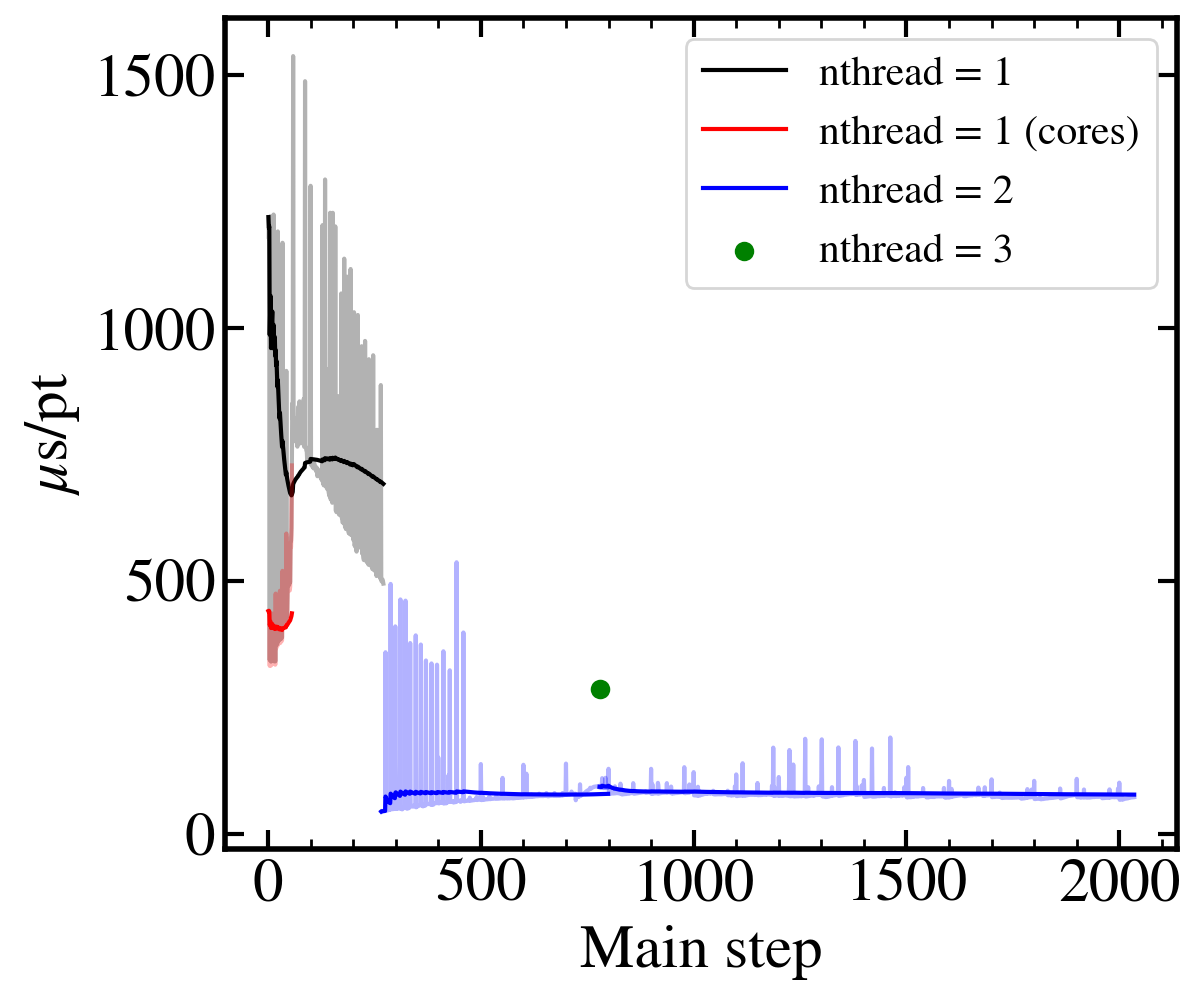

In [118]:
plt.figure(figsize=(6, 5))
plt.plot(log["step_c"], log["tpp1"], c='k', alpha=0.3)
plt.plot(log["step_c"], log["tpp2"], c='k', alpha=1.0, label="nthread = 1")

plt.plot(log1["step_c"], log1["tpp1"], c='r', alpha=0.3)
plt.plot(log1["step_c"], log1["tpp2"], c='r', alpha=1.0, label="nthread = 1 (cores)")

plt.plot(log2a["step_c"], log2a["tpp1"], c='b', alpha=0.3)
plt.plot(log2a["step_c"], log2a["tpp2"], c='b', alpha=1.0, label="nthread = 2")

# plt.plot(log2b["step_c"][1:], log2b["tpp1"], c='b', alpha=0.3)
# plt.plot(log2b["step_c"][1:], log2b["tpp2"], c='b', alpha=1.0)

plt.plot(log2c["step_c"], log2c["tpp1"], c='b', alpha=0.3)
plt.plot(log2c["step_c"], log2c["tpp2"], c='b', alpha=1.0)

plt.scatter(log3["step_c"][1:], log3["tpp1"], c='g', alpha=0.3)
plt.scatter(log3["step_c"][1:], log3["tpp2"], c='g', alpha=1.0, label="nthread = 3")

plt.xlabel("Main step")
plt.ylabel(r"$\mu$s/pt")

plt.legend(fontsize=15)
plt.tight_layout(pad=0.3)

# Computation time in the case of levelmin = 9

In [119]:
fname = "LCDM-2.o14920353.olaf"
with open(fname, "r") as file:
    lines = file.readlines()
lines

[' _/_/_/       _/_/     _/    _/    _/_/_/   _/_/_/_/    _/_/_/  \n',
 ' _/    _/    _/  _/    _/_/_/_/   _/    _/  _/         _/    _/ \n',
 ' _/    _/   _/    _/   _/ _/ _/   _/        _/         _/       \n',
 ' _/_/_/     _/_/_/_/   _/    _/     _/_/    _/_/_/       _/_/   \n',
 ' _/    _/   _/    _/   _/    _/         _/  _/               _/ \n',
 ' _/    _/   _/    _/   _/    _/   _/    _/  _/         _/    _/ \n',
 ' _/    _/   _/    _/   _/    _/    _/_/_/   _/_/_/_/    _/_/_/  \n',
 '                         Version 3.0                            \n',
 '        written by Romain Teyssier (University of Zurich)       \n',
 '                (c) CEA 1999-2007, UZH 2008-2014                \n',
 '  \n',
 ' Working with nproc =  600 for ndim = 3\n',
 '  \n',
 ' IOGROUPSIZECONE=           2\n',
 '  \n',
 '  \n',
 ' compile date = 11/25/24-10:38:54\n',
 ' patch dir    = ../patch/Horizon5-master-2\n',
 ' remote repo  = https://github.com/cosmos-in-us/ramses-hr5.git\n',
 ' local branc

In [121]:
def step_time(fname):
    with open(fname, "r") as file:
        lines = file.readlines()

    step_tot = []
    time_tot = []
    for line in lines:
        if "Main step" in line:
#             print(line)
#             print(line.split()[2])
            step = line.split()[2]
            step_tot.append(int(step))
        if "Total running time" in line:
#             print(line)
#             print(line.split()[-2])
            time = line.split()[-2]
            time_tot.append(float(time))
        
    step_tot = np.array(step_tot)
    time_tot = np.array(time_tot)

    return step_tot, time_tot

In [122]:
step1, time1 = step_time("LCDM.o14904358.olaf")
step2, time2 = step_time("LCDM-2.o14907045.olaf")
step3, time3 = step_time("LCDM-2.o14920353.olaf")

In [123]:
step2[0], step3[0]

(266, 779)

<IPython.core.display.Javascript object>


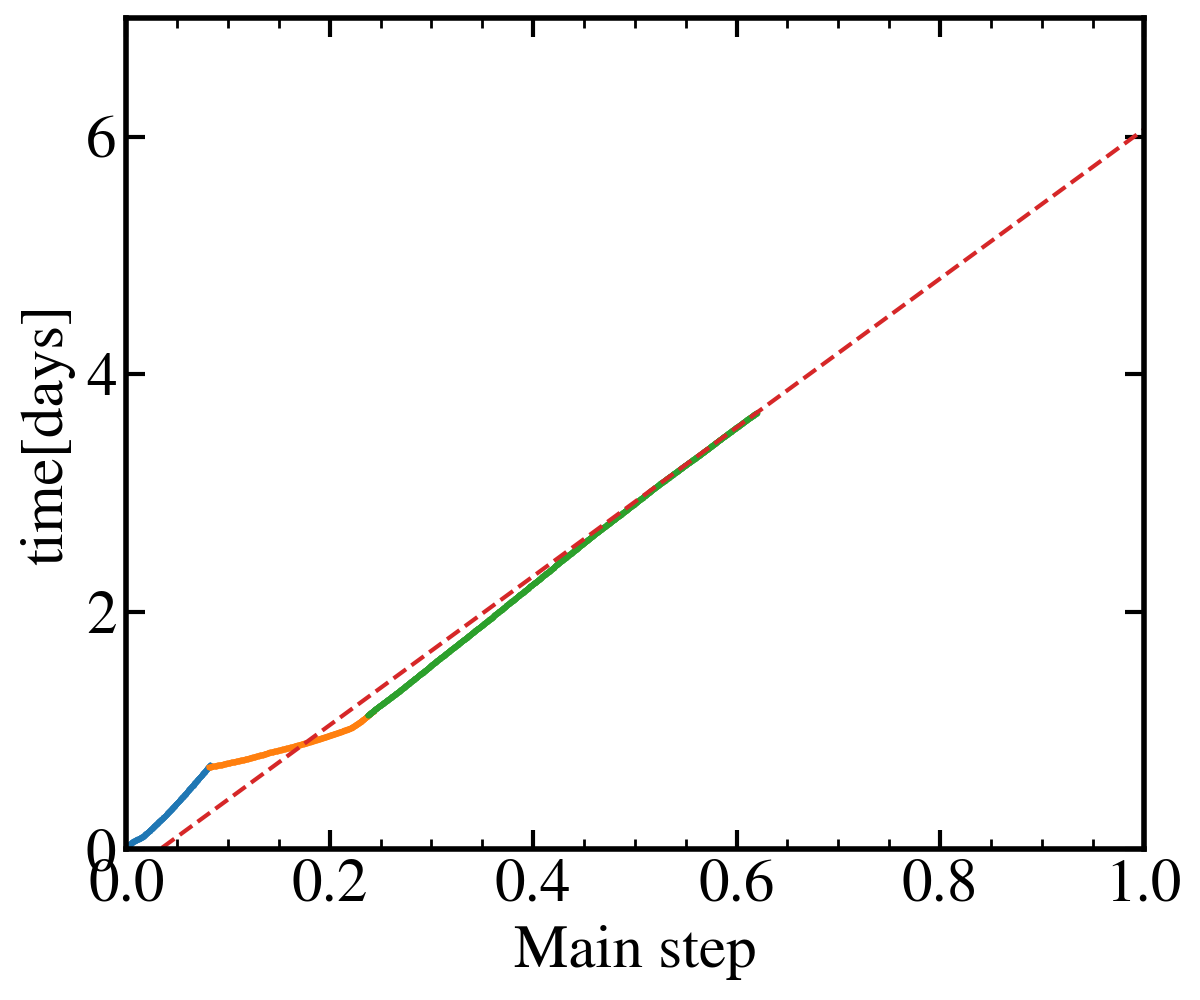

In [149]:
plt.figure(figsize=(6, 5))
plt.plot(step1 * 106 / 171 /step3[-1], time1[1:]/3600/24, 'o-', ms=1)
plt.plot(step2 * 106 / 171 /step3[-1], time2[1:]/3600/24 + time1[np.where(step1==step2[0])]/3600/24, 'o-', ms=1)
plt.plot(step3 * 106 / 171 /step3[-1], time3[1:]/3600/24 + time1[np.where(step1==step2[0])]/3600/24 + time2[np.where(step2==step3[0])]/3600/24, 'o-', ms=1)

plt.xlim(0, 1)
plt.ylim(0, 7)
plt.xlabel("Main step")
plt.ylabel("time[days]")
plt.tight_layout(pad=0.3)

In [151]:
x0 = 106 / 171
y0 = time3[-1] + time1[np.where(step1==step2[0])] + time2[np.where(step2==step3[0])]
y0 /= 3600*24

dx = step3[-1] - step3[-2]
dx *= 106 / 171 /step3[-1]
dy = time3[-1] - time3[-2]
dy /= 3600*24

In [152]:
x = np.linspace(0, 1, 101)

In [153]:
y = dy/dx * (x-x0) + y0

In [154]:
plt.plot(x,y, ls="--")

In [155]:
# ~ 6 days for one simulation?